In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from Plot_XZ import *
from PCA import *

[ 0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  3.  2.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  3.  3.
  0.  0.  0.  3.  4.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.  0.  1.  2.  2.  2.
  0.  0.  1.  1.  1.  1.  0.  0.  2.  1.  3.  3.  0.  0.  1.  2.  2.  2.]


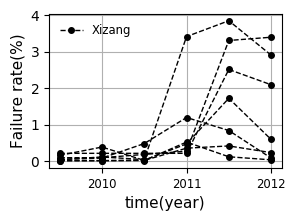

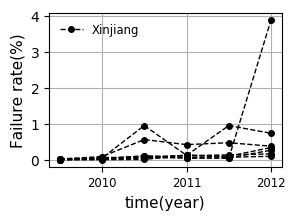

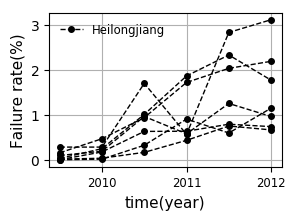

In [2]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])

# #特征因素分析
elec_tem = elec_data.Tem.values + SNR[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# data_cs_year[42:45] = 12
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char3 = elec_Pca1[:, 2] # 降维特征2
# print(elec_Pca_char1)
elec_data.Fault.values[53] =3008
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)
# elec_faults[25] = 3
# elec_faults[39] = 5
# elec_faults[53] = 3.8
# print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(data_cs_year))
Num_shared = shared(np.asarray(companyABC))
# 画图
# Plot_XZ(elec_year2, elec_faults2, Savefig)

def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

In [ ]:
from matplotlib import gridspec
# 最后两个变量因素的主成分最大。故只画出最后两个的图
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2)
ip=1
ax = plt.subplot(gs[ip])
# for i in np.arange(3):
# ax.plot(elec_Pca[:, 2],elec_Pca[:, 0],'o')
# ax.plot(elec_Pca[:, 2],elec_Pca[:, 1],'o')
ax.plot(elec_Pca[:, 2],elec_Pca[:, 3],'o-')
# ax.plot(elec_Pca[:, 0],elec_Pca[:, (i+1)],'o')

ax.plot(elec_Pca1[:, 0], elec_Pca1[:, 1], 'ko-')
plt.legend([ 'X2-X3', 'PCA1-PCA2'], loc='upper right')
    
plt.xlabel('x2', fontsize=15)
plt.ylabel('x1', fontsize=12)
plt.show()


fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 1)
for ip in np.arange(1):
    ax = plt.subplot(gs[ip])
    for i in np.arange(2):
        ax.plot(elec_Pca[:, (i+2)],'o')

    ax.plot(elec_Pca1[:, ip], 'ko-')
    ax.plot(elec_Pca1[:, ip+1], 'ro-')
    plt.legend([ '3', '4', 'PCA1','PCA2'], loc='upper right')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# 建模，模型
with pm.Model() as model_1:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    #     sd_5 = pm.HalfNormal('sd_5', 0.5)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', 10)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', 10)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', 10)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', 10)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd_0 = pm.HalfCauchy('sd_0', 20)
#     sd_4 = pm.Uniform('sd_4', lower=0.1, upper=100)
#     sd_3 = pm.Uniform('sd_3', lower=0.1, upper=100)
#     sd_2 = pm.Uniform('sd_2', lower=0.1, upper=100)
#     sd_1 = pm.Uniform('sd_1', lower=0.1, upper=100)
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Normal('u', 0, 0.01)

    beta_mu = pm.Deterministic('beta_mu', tt.exp(u + beta + \
                                             (beta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                              beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_year * xs_year)))

    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值
    trace_1 = pm.sample(3000,  init='advi+adapt_diag' )

In [ ]:
pm.traceplot(trace_1)
plt.show()

In [ ]:
burnin = 2000
chain = trace_1[burnin:]
# get MAP estimate
varnames2 = ['beta', 'beta1', 'beta2', 'beta3','beta4', 'u']
tmp = pm.df_summary(chain, varnames2)
betaMAP = tmp['mean'][0]
beta1MAP = tmp['mean'][np.arange(companiesABC) + 1]
beta2MAP = tmp['mean'][np.arange(companiesABC) + 1*companiesABC+1]
beta3MAP = tmp['mean'][np.arange(companiesABC) + 2*companiesABC+1]
beta4MAP = tmp['mean'][np.arange(companiesABC) + 3*companiesABC+1]
uMAP = tmp['mean'][4*companiesABC+1]

In [ ]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    

    xl = np.linspace(0.5, 6.5, 6)
    yl = np.exp(uMAP + betaMAP + (beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP[ip]*xl*xl))
    
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_1[ips]
        yl2 = np.exp(param['u'] + param['beta'] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
    ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, yl, 'k', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [3]:
# 建模，加上含污染模型对比
with pm.Model() as model_2:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', 10)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', 10)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', 10)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', 10)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd_0 = pm.HalfCauchy('sd_0', 20)
#     sd_4 = pm.Uniform('sd_4', lower=0.1, upper=100)
#     sd_3 = pm.Uniform('sd_3', lower=0.1, upper=100)
#     sd_2 = pm.Uniform('sd_2', lower=0.1, upper=100)
#     sd_1 = pm.Uniform('sd_1', lower=0.1, upper=100)
    
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Normal('u', 0, 0.01)

    liner = pm.Deterministic('liner', tt.exp(u + beta + \
                                             (beta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                              beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_year * xs_year)))

    # latent model for contamination
#     upper = pm.HalfCauchy('upper', 10)
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=7)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(Num_shared.get_value()))
    
    zij_ = pm.theanof.tt_rng().uniform(size=companyABC.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[Num_shared]))   
#     phic = pm.Uniform('phic', lower=0, upper=1, testval=.3)
#     zij = pm.Bernoulli('zij', p=phic, shape=len(Num_shared.get_value()))
#     line = tt.constant(np.ones(len(Num_shared.get_value())) * .5)
#     beta_mu = pm.Deterministic('beta_mu', tt.squeeze(tt.switch(tt.eq(zij, 0), liner, line)))
    beta_mu = pm.Deterministic('beta_mu', tt.switch(zij, liner, pi_ij))
    
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值
    #     start = pm.find_MAP()
#     step = pm.Metropolis([zij])
# #     step1 = pm.NUTS(scaling=cov, is_cov=True)
#     #     step1 = pm.Slice([am0, am1])
#     trace = pm.sample(4000, step=[step], init='advi+adapt_diag', tune=1000)
import theano
with model_2:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_2 = approx.sample(3000, include_transformed=True)
    elbos1 = -inference.hist

Average Loss = 147.55: 100%|████████████████████████████████████████████████████| 20000/20000 [00:31<00:00, 640.91it/s]
Finished [100%]: Average Loss = 147.41
Average Loss = 107.2: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 972.02it/s]
Finished [100%]: Average Loss = 107.08


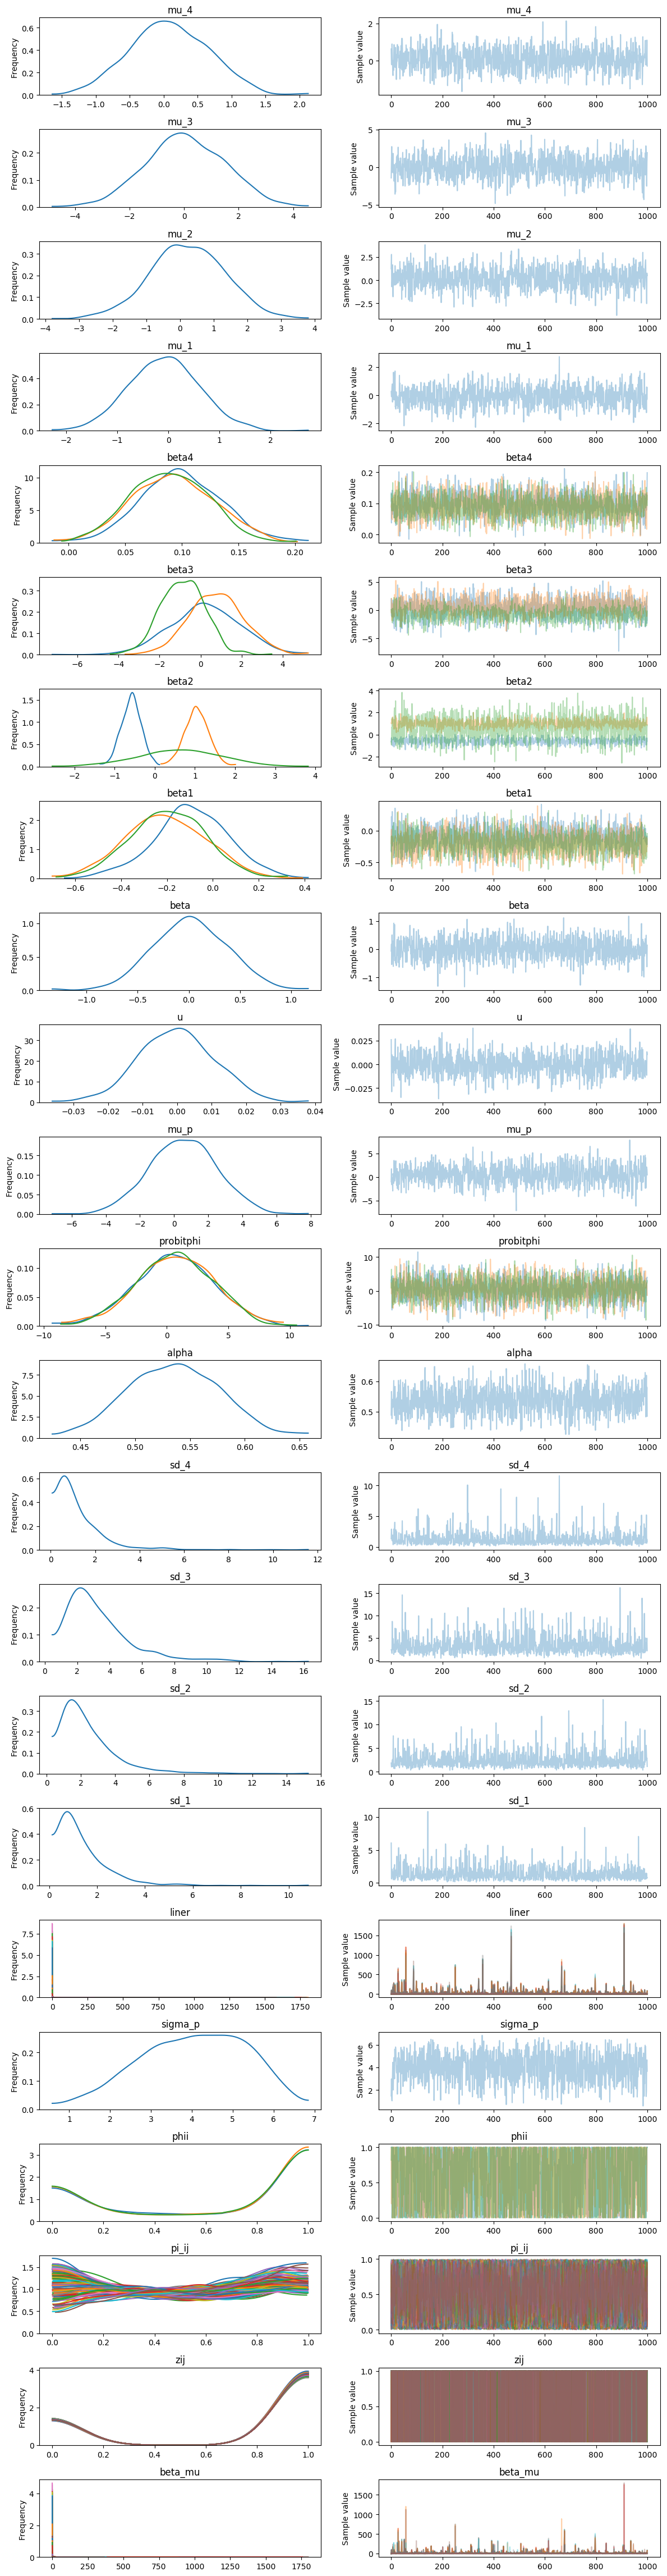

In [4]:
chain_2 = trace_2[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_2)
plt.show()

In [5]:
njob = 1
start = trace_2[0]
start['zij'] = start['zij'].astype(int)
stds = approx.bij.rmap(approx.std.eval())
cov = model_2.dict_to_array(stds) ** 2
# 建模，加上含污染模型对比
with pm.Model() as model_2b:
    # define priors 
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', 10)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', 10)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', 10)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', 10)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd_0 = pm.HalfCauchy('sd_0', 20)
#     sd_4 = pm.Uniform('sd_4', lower=0.1, upper=100)
#     sd_3 = pm.Uniform('sd_3', lower=0.1, upper=100)
#     sd_2 = pm.Uniform('sd_2', lower=0.1, upper=100)
#     sd_1 = pm.Uniform('sd_1', lower=0.1, upper=100)

    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Normal('u', 0, 0.01)

    liner = pm.Deterministic('liner', tt.exp(u + beta + \
                                             (beta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                              beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_year * xs_year)))

    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(Num_shared.get_value()))
    
    
    # latent model for contamination
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=7)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))   
    
    zij = pm.Bernoulli('zij', p=phii[Num_shared], shape=len(Num_shared.get_value()))
#     phic = pm.Uniform('phic', lower=0, upper=1, testval=.3)
#     zij = pm.Bernoulli('zij', p=phic, shape=len(Num_shared.get_value()))
#     line = tt.constant(np.ones(len(Num_shared.get_value())) * .5)
#     beta_mu = pm.Deterministic('beta_mu', tt.squeeze(tt.switch(tt.eq(zij, 0), liner, line)))
    beta_mu = pm.Deterministic('beta_mu', tt.switch(tt.eq(zij, 0), liner, pi_ij))
    
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值
    
#     step1 = pm.Metropolis([zij])
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace_2b = pm.sample(4000, step=[step], start=start, njobs=njob, turn =1000)
#     trace_2b = pm.sample(4000,  init='advi+adapt_diag', njobs=njob)

Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 4499/4500 [03:50<00:00, 19.51it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.538512133724, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 1511 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [03:50<00:00, 19.51it/s]


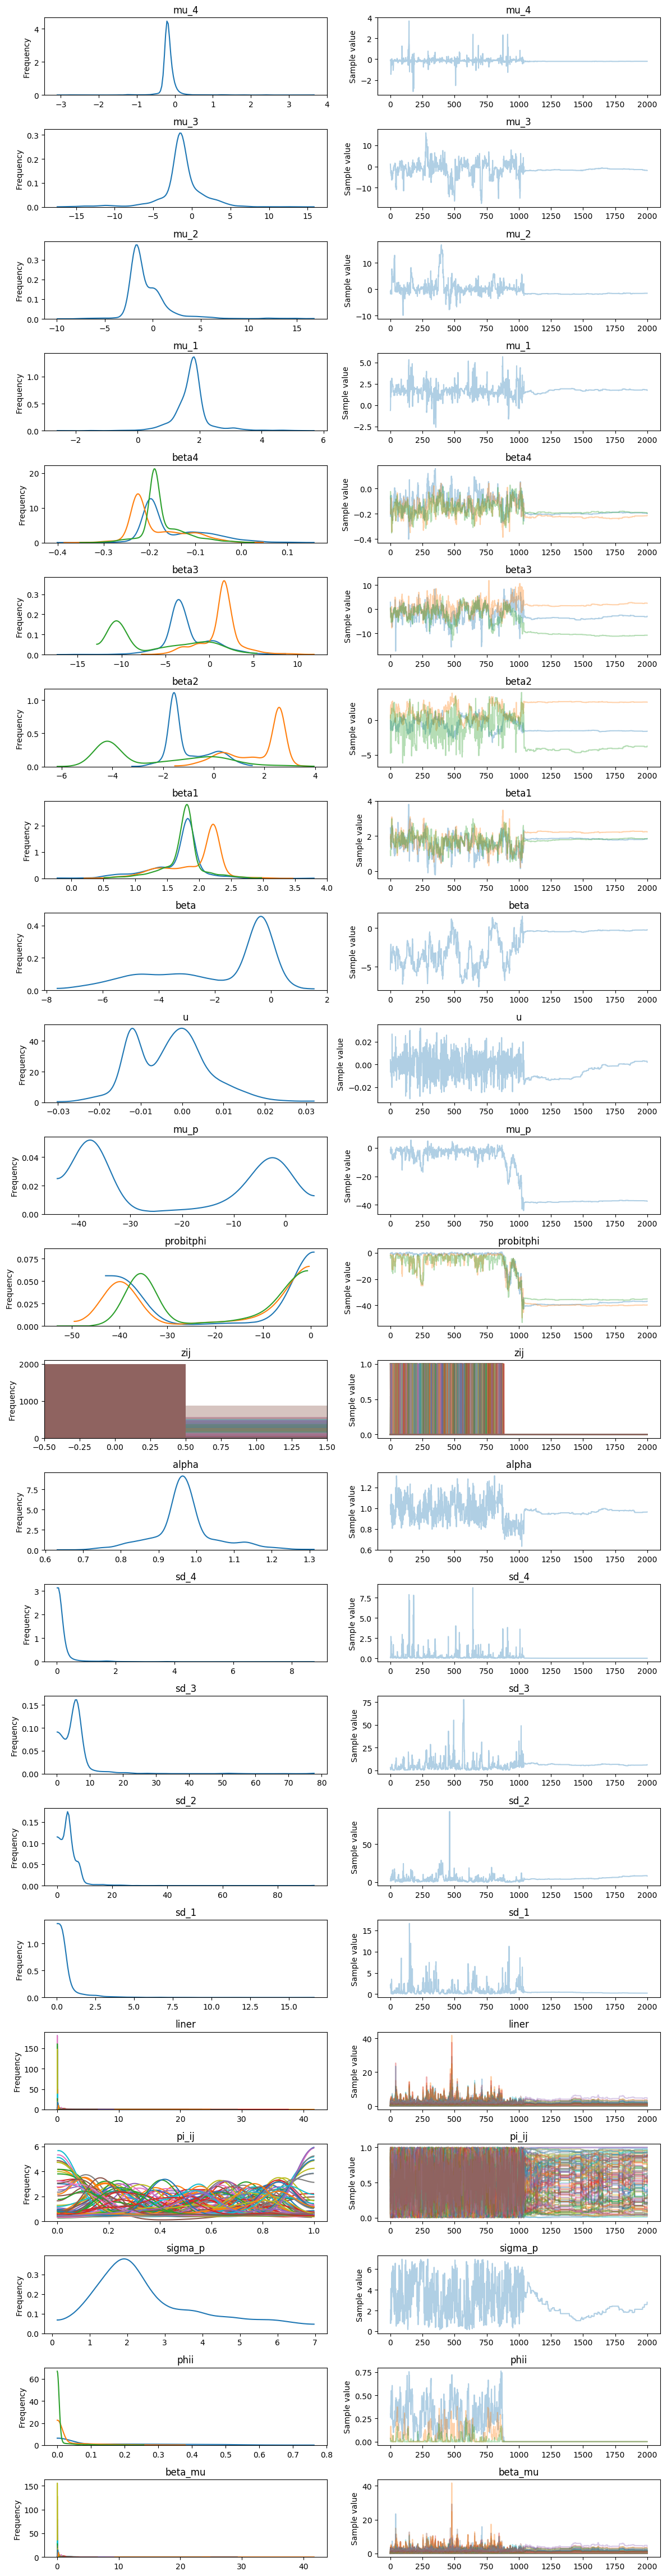

In [6]:
chain_2b = trace_2b[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_2b)
plt.show()

In [7]:
varnames2b = ['beta', 'beta1', 'beta2', 'beta3','beta4', 'u']
tmp2 = pm.df_summary(chain_2b, varnames2b)
betaMAP2 = tmp2['mean'][0]
beta1MAP2 = tmp2['mean'][np.arange(companiesABC) + 1]
beta2MAP2 = tmp2['mean'][np.arange(companiesABC) + 1*companiesABC+1]
beta3MAP2 = tmp2['mean'][np.arange(companiesABC) + 2*companiesABC+1]
beta4MAP2 = tmp2['mean'][np.arange(companiesABC) + 3*companiesABC+1]
uMAP2 = tmp2['mean'][4*companiesABC+1]
# am0MAP = tmp['mean'][4*companiesABC+2]
# am1MAP = tmp['mean'][4*companiesABC+3]
# print(am0MAP)
# print(beta1MAP)
# print(tmp)
# print(beta2MAP)
# print(beta3MAP)

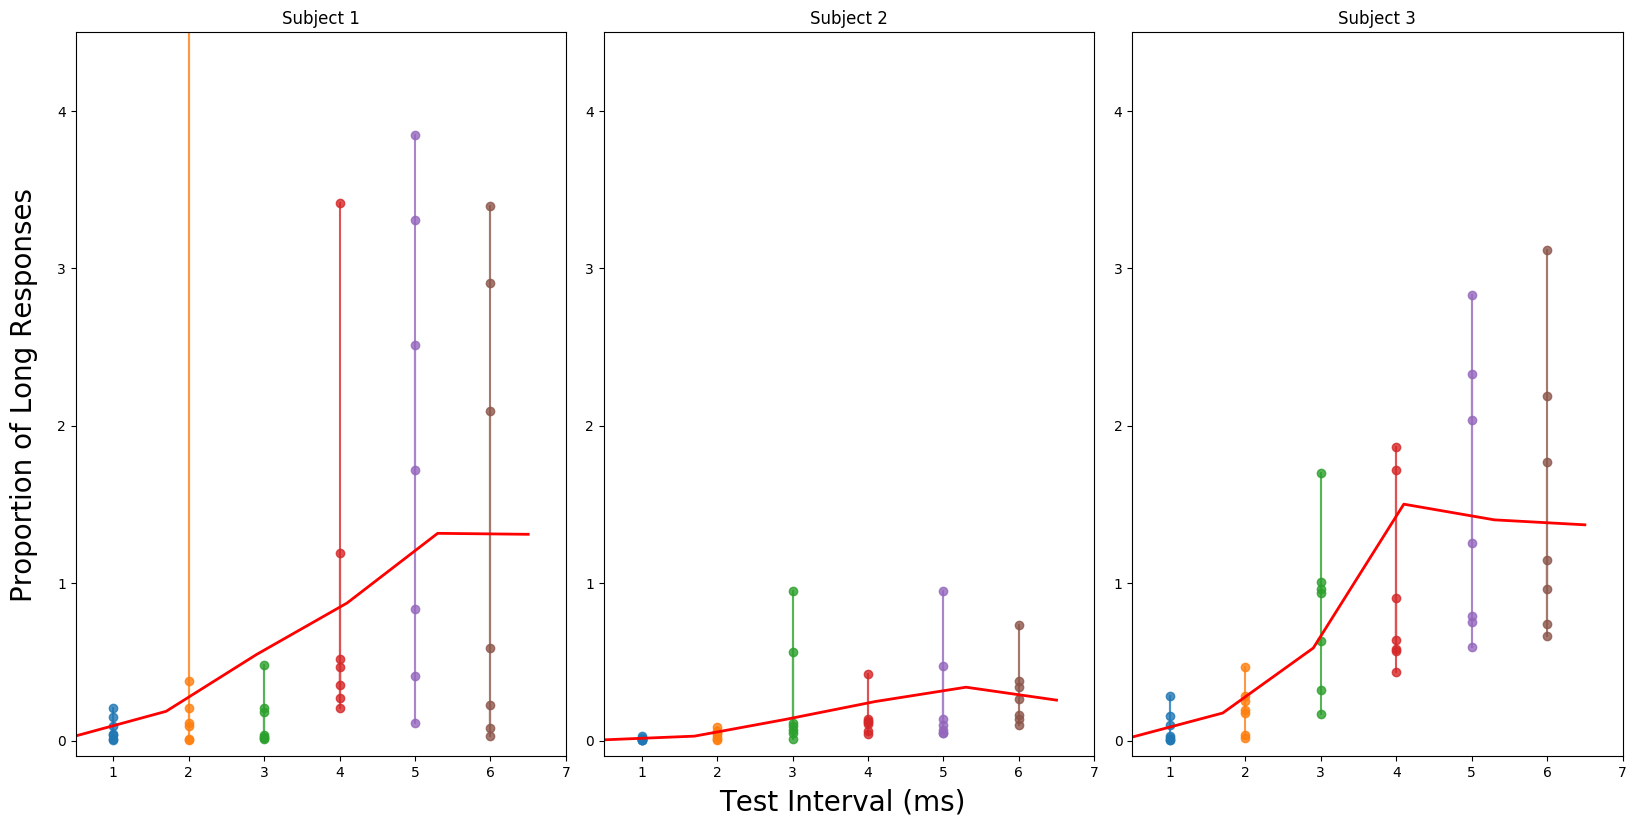

In [8]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    

    xl = np.linspace(0.5, 6.5, 6)
    yl = np.exp(uMAP + betaMAP + (beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP[ip]*xl*xl))
    
    y2 = np.exp(uMAP2 + betaMAP2 + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))   
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_2b[ips]
        yl2 = np.exp(param['u'] + param['beta'] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, yl, 'k--', linewidth=2)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [ ]:
WAIC = pm.compare([trace_1, trace_2b], [model_1, model_2b], ic='WAIC')
print(WAIC)

In [ ]:
# 跟随特征变化分析
from scipy.stats.kde import gaussian_kde
burnin = 2000
kde_beta2 = trace_2b['beta2'][burnin:]
kde_beta3 = trace_2b['beta3'][burnin:]

fig = plt.figure(figsize=(15, 12))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(3, 3)
ppcsamples = 100
burnin = 2000

ylabes = ['XiZang', 'XinJiang', 'HeiLongJiang']

for ip in np.arange(companiesABC):
    ax0 = plt.subplot(gs[ip*3])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    ax0.plot(xp, yp, marker='o', alpha=.8)
    plt.ylabel(ylabes[ip], fontsize=12)
    plt.xlabel('Years' , fontsize=12)
    
    x0 = np.linspace(0.5, 6, 6)
    y0 = np.exp(uMAP + betaMAP + beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+6)] ++ beta4MAP[ip]*xl*xl)
    
    # Posterior sample from the trace
#     for ips in np.random.randint(burnin, 3000, ppcsamples):
#         param = trace[ips]
#         yl2 = np.exp(param['beta'][ip] + param['beta1'][ip] * (xl) + param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+40)] + \
#                      param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+40)])
#         ax0.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
    ax1 = plt.subplot(gs[1+ip*3])
    my_pdf1 = gaussian_kde(kde_beta2[:, ip])
    x1 = np.linspace(-8, 8, 300)
    ax1.plot(x1, my_pdf1(x1), 'k', lw=2.5, alpha=0.6)
    plt.xlim((-8, 8))
    plt.xlabel(r'$\beta2$', fontsize=15)
    plt.ylabel('Posterior Density', fontsize=12)
    
    ax2 = plt.subplot(gs[2+ip*3])
    my_pdf2 = gaussian_kde(kde_beta3[:, ip])
    x2 = np.linspace(-6, 6, 300)
    ax2.plot(x2, my_pdf2(x2), 'k', lw=2.5, alpha=0.6)
    plt.xlim((-6, 6))
    plt.xlabel(r'$\beta3$', fontsize=15)
    plt.ylabel('Posterior Density', fontsize=12)
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [ ]:
# 后验分析
ppc = pm.sample_ppc(trace_2b, samples=1000, model=model_2b)
yipred = ppc['Observed']
# plt.hist(yipred, normed=1, bins=80, alpha=.8, label='Posterior')
# plt.show()
plt.figure()
ax = sns.distplot(ppc['Observed'].mean(axis=1), label='Posterior predictive means') # axis=1以行方式计算
ax.axvline(elec_faults.mean(), color='r', ls='--', label='True mean')
ax.legend()
plt.show()

In [ ]:
# 第七年数据测试，读取测试数据集特征,
data_cs = pd.read_csv('XZ_CS.csv')
SNR_cs = np.random.normal(0, 2, size=[len(data_cs.Tem.values), 4])
datax_cs = np.array(data_cs)[:,0:4] + SNR_cs # 添加噪声

data_cs_year = data_cs.Year.values # 测试数据时间
data_cs_num  = data_cs.Count.values # 测试数据参考位置,这么做就是整数

meanVal = np.mean(datax_cs, axis=0)  # 按列求均值，即求各个特征的均值
newData_mean = datax_cs - meanVal
StdVal  = np.std(datax_cs, axis=0)
newData_std = newData_mean/StdVal


pca = PCA(n_components=2)
pca.fit(newData_std)
Pca_cs = pca.transform(newData_std) # 测试数据PCA特征值，直接调用即可，但是之调用这条也会出问题
Pca_cs_char1 = Pca_cs[:, 0]
Pca_cs_char2 = Pca_cs[:, 1]
print(data_cs_year)
print(data_cs_num)
# print(Pca_cs)

# print(pm.waic(trace, model1))

In [ ]:
# 测试数据结果显示
# print(data_cs_year)
xs_year.set_value(np.asarray(data_cs_year))
Num_shared.set_value(np.asarray(data_cs_num))
xs_char1.set_value(np.asarray(Pca_cs_char1))
xs_char2.set_value(np.asarray(Pca_cs_char2))

with model_2b:
    ppcc = pm.sample_ppc(trace_2b)
post_pred = ppcc['Observed']
yipred_mean = post_pred.mean(axis=0)

print(yipred_mean)

# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
xipred={}

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)
    
    yipred_yplot = np.array([yipred_mean[i*6:(i+1)*6] for i in np.arange(7*ip, (ip+1)*7)])
    xipred = np.array([np.arange(6)+1 for i in np.arange(7)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')
    
plt.tight_layout()
plt.show()

In [ ]:
# 应用偏最小二乘PLS来进行仿真
from sklearn.cross_decomposition import PLSRegression
X_PLSR = np.vstack((elec_year, elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
X_PLSR_XZ = X_PLSR[:42, :]
X_PLSR_XJ = X_PLSR[42:84, :]
X_PLSR_HLJ = X_PLSR[84:, :]
# X_PLSR_HLJ[:5, 0]=7
# print(X_PLSR_HLJ)
Y_PLSR = elec_faults
Y_PLSR_XZ = Y_PLSR[:42]
Y_PLSR_XJ = Y_PLSR[42:84]
Y_PLSR_HLJ = Y_PLSR[84:]
# print(Y_PLSR_XZ)


pls_XZ = PLSRegression(n_components=2)
pls_XZ.fit(X_PLSR_XZ, Y_PLSR_XZ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XZ = pls_XZ.predict(X_PLSR_XZ)
Y_PLSpred_XZ =  np.vstack((Y_PLSpred_XZ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XZ)

pls_XJ = PLSRegression(n_components=2)
pls_XJ.fit(X_PLSR_XJ, Y_PLSR_XJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XJ = pls_XJ.predict(X_PLSR_XJ)
Y_PLSpred_XJ =  np.vstack((Y_PLSpred_XJ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XJ)


pls_HLJ = PLSRegression(n_components=2)
pls_HLJ.fit(X_PLSR_HLJ, Y_PLSR_HLJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_HLJ, Y_PLSR_HLJ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_HLJ = pls_HLJ.predict(X_PLSR_HLJ)
Y_PLSpred_HLJ =  np.vstack((Y_PLSpred_HLJ).T)[0]
# print(Y_PLSpred_HLJ)
# print(Y_train_r)

Y_PLSpred = np.vstack((Y_PLSpred_XZ, Y_PLSpred_XJ, Y_PLSpred_HLJ))# Pls预测值
Y_PLSpred_Target = np.vstack((Y_PLSR_XZ, Y_PLSR_XJ, Y_PLSR_HLJ)) # 目标值
# print(Y_PLSpred)
# print(Y_PLSpred)

aaa = pls_HLJ.get_params(deep=True) # 获取参数
print(aaa)

In [ ]:
# 计算均方误差
def Rmse(predictions, targets):
    return  np.sqrt(np.mean((predictions - targets)**2))

rmse = {}
for ip in np.arange(3):
    rmse[ip] = Rmse(Y_PLSpred_Target[ip, :], Y_PLSpred[ip, :])

print(rmse)

In [ ]:
# 将预测值转化为均值形式
AAA = np.array([Y_PLSpred_XZ[i*6:(i+1)*6] for i in np.arange(7)])
BBB = np.array([Y_PLSpred_XJ[i*6:(i+1)*6] for i in np.arange(7)])
CCC = np.array([Y_PLSpred_HLJ[i*6:(i+1)*6] for i in np.arange(7)])
XZ_mean = AAA[:].mean(axis=0)
XJ_mean = BBB[:].mean(axis=0)
HLJ_mean = CCC[:].mean(axis=0)
Y_PLSpred_MEAN = np.vstack((XZ_mean, XJ_mean, HLJ_mean))# Pls预测值
print(Y_PLSpred_MEAN)
# print(HLJ_mean)

In [ ]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
xipred = np.array(np.arange(6) + 1)

for ip in np.arange(3):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    yipred_yplot = np.array(Y_PLSpred_MEAN[ip])

    ax.plot(xipred, yipred_yplot, 'k*-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()